## Ring-hydroxylating Dioxygenases

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re
from prince import CA, MCA
import matplotlib.cm as cm
from Bio.SeqUtils import seq3
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pyclustering.cluster.optics import optics
from pyclustering.cluster.optics import ordering_analyser
import networkx as nx

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
file = 'alignment.fasta'
msa = list(SeqIO.parse(file, "fasta"))
msa

[SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A1V1ZE67_9FLAO/178-361', name='A0A1V1ZE67_9FLAO/178-361', description='A0A1V1ZE67_9FLAO/178-361', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A0J1DCU0_9BURK/170-416', name='A0A0J1DCU0_9BURK/170-416', description='A0A0J1DCU0_9BURK/170-416', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='J2WKD9_9SPHN/182-387', name='J2WKD9_9SPHN/182-387', description='J2WKD9_9SPHN/182-387', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A1Q3AVG0_CEPFO/233-414', name='A0A1Q3AVG0_CEPFO/233-414', description='A0A1Q3AVG0_CEPFO/233-414', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A5N0VGT3_9PSEU/179-385', name='A0A5N0VGT3_9PSEU/179-385', description='A0A5N0VGT3_9PSEU/179-385', dbxrefs=[]),
 SeqRec

In [3]:
# metadata, raw_data =
headers, sequences = [], []
for row in msa:
    headers.append(row.id)
    sequences.append(row.seq)
raw = np.array(sequences)
raw.shape

(9381, 1225)

In [4]:
# Define the set of values to replace
df = pd.DataFrame(raw).replace(['-', *[chr(i) for i in range(ord('a'), ord('z')+1)]], np.nan)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Set the threshold for non-null values
threshold = .85
min_rows = int(threshold * df.shape[0])

# Remove columns with NaN values above the threshold
df.dropna(thresh=min_rows, axis=1, inplace=True)
min_cols = int(threshold * df.shape[1])

print(min_rows, min_cols)

# Remove rows with NaN values above the threshold
df.dropna(thresh=min_cols, axis=0, inplace=True)

row_idx = df.index
col_idx = df.columns

df.head()

7973 89


,150,177,178,179,180,181,182,185,186,187,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,H,V,N,C,H,W,A,L,Y,C,...,E,L,V,N,K,G,V,Q,S,R
1,R,I,K,G,D,W,K,L,Y,M,...,E,Y,S,C,A,G,I,Q,A,R
2,D,I,D,A,N,W,K,L,T,Y,...,E,A,G,Q,R,G,L,N,S,G
3,T,L,E,C,N,W,K,V,F,C,...,E,G,V,Q,R,G,L,E,S,P
4,E,I,E,A,N,W,K,V,V,N,...,E,N,V,Q,R,G,M,N,T,S


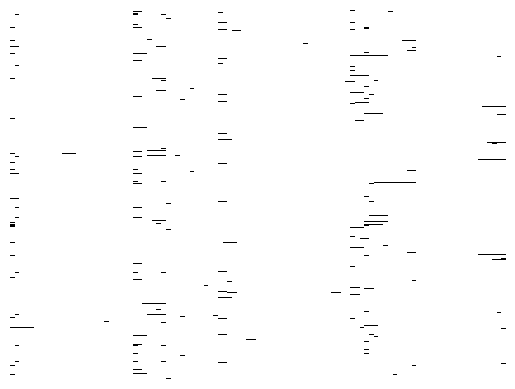

In [9]:
# Plot the heatmap
sns.heatmap(df.isna().astype(int), cmap='binary', xticklabels=False, yticklabels=False, cbar=False)

# Show the plot
plt.show()

In [12]:
# Join the dataframes based on the 'ID' column
df = pd.merge(
    pd.merge(
        pd.read_csv('data.tsv', delimiter='\t'),
        pd.DataFrame(
            {
                'Entry':[headers[idx].split('/')[0].split('_')[0] for idx in df.index],
                'Index':list(df.index)
            }
        ),
        on='Entry'
    ),
    df,
    left_on='Index',
    right_index=True,
    how='inner'
)
df['EC number'].apply(lambda x: x.split('; ') if x else [], inplace=True)
df.head()

,Entry,Entry Name,Protein names,EC number,Index,150,177,178,179,180,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,A0A401KD97,A0A401KD97_ASPAW,Bifunctional lycopene cyclase/phytoene synthas...,"[1.14.15.7, 2.5.1.32, 5.5.1.19]",2247,D,V,E,A,N,...,V,G,A,Q,E,N,L,S,A,G
1,A0A024HID4,A0A024HID4_PSEKB,Carnitine monooxygenase oxygenase subunit (EC ...,[1.14.13.239],7717,R,T,P,A,N,...,E,S,V,Q,K,G,L,K,S,R
2,A0A0B7G8U8,A0A0B7G8U8_KLEVA,Carnitine monooxygenase oxygenase subunit (EC ...,[1.14.13.239],2106,L,T,P,A,N,...,E,S,V,Q,K,G,L,K,S,R
3,A0A0D1ZK14,A0A0D1ZK14_9EURO,"Choline monooxygenase, chloroplastic (EC 1.14....",[1.14.15.7],5410,Q,G,Q,Y,N,...,N,A,A,Q,K,N,L,N,A,G
4,A0A0F3KB91,A0A0F3KB91_9NEIS,Carnitine monooxygenase oxygenase subunit (EC ...,[1.14.13.239],3208,A,T,P,A,N,...,E,S,V,Q,R,G,L,K,S,R


In [13]:
df['Protein names'].value_counts(normalize=True)

Protein names
Choline monooxygenase, chloroplastic (EC 1.14.15.7)                                                    0.421416
Anthranilate 1,2-dioxygenase large subunit (EC 1.14.12.1)                                              0.108808
3-phenylpropionate/cinnamic acid dioxygenase subunit alpha (EC 1.14.12.19)                             0.041451
Carnitine monooxygenase oxygenase subunit (EC 1.14.13.239) (Carnitine monooxygenase alpha subunit)     0.029361
Benzoate 1,2-dioxygenase large subunit (EC 1.14.12.10)                                                 0.028497
                                                                                                         ...   
Dioxygenase subunit (EC 1.14.12.1)                                                                     0.000864
Ring hydroxylating alpha subunit (EC 1.14.12.1)                                                        0.000864
Dioxygenase (EC 1.14.12.3)                                                                

In [14]:
# Extract the substrate and enzyme names using regular expressions
matches = df['Protein names'].str.extract(r'(.+?) ([\w\-,]+ase)', flags=re.IGNORECASE)

# String normalization pipeline
df['Substrate'] = matches[0]\
    .fillna('')\
    .apply(lambda x: '/'.join(re.findall(r'\b(\w+(?:ene|ine|ate|yl))\b', x, flags=re.IGNORECASE)))\
    .apply(lambda x: x.lower())

df['Enzyme'] = matches[1]\
    .fillna('')\
    .apply(lambda x: x.split('-')[-1] if '-' in x else x) \
    .apply(lambda x: x.lower())

df.reset_index(drop=True)

df[['Substrate', 'Enzyme']].value_counts(normalize=True)

Substrate                               Enzyme        
choline                                 monooxygenase     0.442142
anthranilate                            dioxygenase       0.120898
benzoate                                dioxygenase       0.065630
phenylpropionate                        dioxygenase       0.055268
carnitine                               monooxygenase     0.048359
biphenyl                                dioxygenase       0.041451
                                                          0.037997
                                        dioxygenase       0.031088
halobenzoate                            dioxygenase       0.031088
salicylate                              hydroxylase       0.030225
naphthalene                             dioxygenase       0.030225
benzene                                 dioxygenase       0.021589
terephthalate                           dioxygenase       0.012090
methanesulfonate                        monooxygenase     0.007772
aminobe

In [15]:
df['Enzyme'].value_counts(normalize=True)

Enzyme
monooxygenase     0.498273
dioxygenase       0.429188
                  0.037997
hydroxylase       0.031952
cyclase           0.000864
decarboxylase     0.000864
oxidoreductase    0.000864
Name: proportion, dtype: float64

In [16]:
df['Substrate'].value_counts(normalize=True)

Substrate
choline                                   0.442142
anthranilate                              0.120898
                                          0.071675
benzoate                                  0.065630
phenylpropionate                          0.055268
carnitine                                 0.048359
biphenyl                                  0.041451
halobenzoate                              0.031088
salicylate                                0.030225
naphthalene                               0.030225
benzene                                   0.021589
terephthalate                             0.012090
methanesulfonate                          0.007772
aminobenzenesulfonate                     0.006045
chlorobenzoate                            0.003454
toluate                                   0.002591
phenylpropanoate                          0.002591
cumate                                    0.000864
lycopene                                  0.000864
phenylpropionate/cinn

In [17]:
df['Label'] = df['Substrate'].str.cat(df['Enzyme'], sep=' ').str.strip()
df.reset_index(drop=True)
df['Label'].value_counts(normalize=True)

Label
choline monooxygenase                                   0.442142
anthranilate dioxygenase                                0.120898
benzoate dioxygenase                                    0.065630
phenylpropionate dioxygenase                            0.055268
carnitine monooxygenase                                 0.048359
biphenyl dioxygenase                                    0.041451
                                                        0.037997
halobenzoate dioxygenase                                0.031088
dioxygenase                                             0.031088
salicylate hydroxylase                                  0.030225
naphthalene dioxygenase                                 0.030225
benzene dioxygenase                                     0.021589
terephthalate dioxygenase                               0.012090
methanesulfonate monooxygenase                          0.007772
aminobenzenesulfonate dioxygenase                       0.006045
chlorobenzoate diox

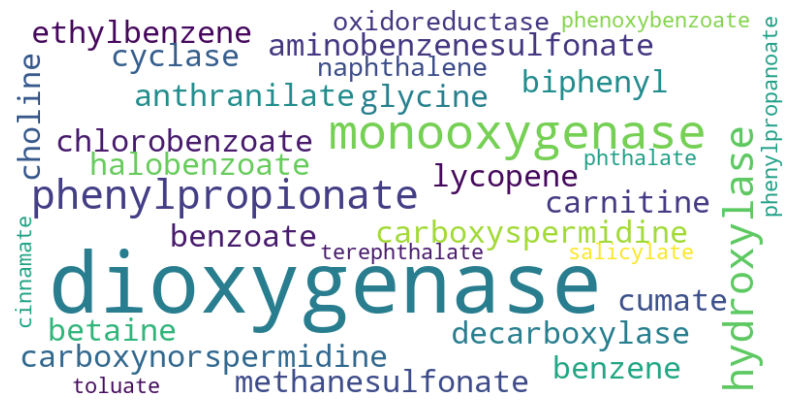

In [18]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(
    WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(
        ' '.join(
            sorted(
                set([string for string in df.Label.values.tolist() if len(string) > 0])
            )
        )
    ),
    interpolation='bilinear'
)
plt.axis('off')
plt.show()

In [20]:
data = pd.concat(
    [
        df[col_idx],
        df.Label
    ],
    axis=1
).drop_duplicates(inplace=True).fillna('-').copy()
data.head()

,150,177,178,179,180,181,182,185,186,187,...,997,1001,1005,1006,1007,1013,1014,1015,1053,Label
0,D,V,E,A,N,W,K,L,L,I,...,G,A,Q,E,N,L,S,A,G,lycopene cyclase
1,R,T,P,A,N,W,K,S,I,V,...,S,V,Q,K,G,L,K,S,R,carnitine monooxygenase
2,L,T,P,A,N,W,K,N,I,V,...,S,V,Q,K,G,L,K,S,R,carnitine monooxygenase
3,Q,G,Q,Y,N,W,K,T,L,A,...,A,A,Q,K,N,L,N,A,G,choline monooxygenase
4,A,T,P,A,N,W,K,I,I,V,...,S,V,Q,R,G,L,K,S,R,carnitine monooxygenase


In [21]:
data.Label.value_counts(normalize=True)

Label
choline monooxygenase                                   0.410517
anthranilate dioxygenase                                0.129151
benzoate dioxygenase                                    0.068266
phenylpropionate dioxygenase                            0.059041
carnitine monooxygenase                                 0.047048
biphenyl dioxygenase                                    0.044280
                                                        0.040590
halobenzoate dioxygenase                                0.033210
dioxygenase                                             0.033210
salicylate hydroxylase                                  0.032288
naphthalene dioxygenase                                 0.032288
benzene dioxygenase                                     0.023063
terephthalate dioxygenase                               0.012915
methanesulfonate monooxygenase                          0.008303
aminobenzenesulfonate dioxygenase                       0.006458
chlorobenzoate diox

In [22]:
# Assuming you have a DataFrame called 'df_unique' with the target column 'Label' and the feature columns 'features'
X = data.drop('Label', axis=1)
y = pd.get_dummies(data.Label).astype(int)

# Perform one-hot encoding on the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Get the column names for the encoded features
encoded_feature_names = []
for i, column in enumerate(X.columns):
    categories = encoder.categories_[i]
    for category in categories:
        feature_name = f'{column}_{category}'
        encoded_feature_names.append(feature_name)

# Convert X_encoded to DataFrame
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded, columns=encoded_feature_names)

# Create and train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_encoded_df, y)

# Feature selection
feature_selector = SelectFromModel(rf, threshold='median')
X_selected = feature_selector.fit_transform(X_encoded_df, y)

selected_feature_indices = feature_selector.get_support(indices=True)
selected_features = X_encoded_df.columns[selected_feature_indices]

selected_features

Index(['150_A', '150_D', '150_E', '150_H', '150_I', '150_L', '150_P', '150_R',
       '150_T', '150_V',
       ...
       '1053_E', '1053_G', '1053_K', '1053_L', '1053_N', '1053_P', '1053_Q',
       '1053_R', '1053_S', '1053_T'],
      dtype='object', length=896)

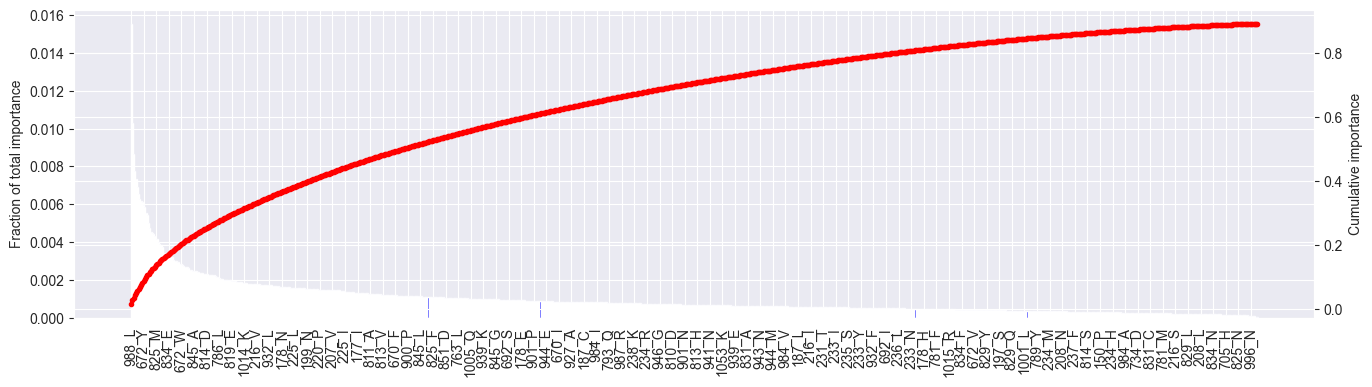

In [23]:
fig, ax1 = plt.subplots(figsize=(16, 4))

# Sort feature importances in descending order
sorted_indices = np.argsort(rf.feature_importances_[selected_feature_indices])[::-1]
sorted_importances = rf.feature_importances_[selected_feature_indices][sorted_indices]
sorted_features = selected_features[sorted_indices]

# Bar chart of percentage importance
xvalues = range(len(sorted_features))
ax1.bar(xvalues, sorted_importances, color='b')
ax1.set_ylabel('Fraction of total importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, np.cumsum(sorted_importances), color='r', marker='.')
ax2.set_ylabel('Cumulative importance')
ax2.tick_params(axis='y')

# Set x-axis tick labels at every 10th index
xtick_interval = 10
plt.xticks(xvalues[::xtick_interval], sorted_features[::xtick_interval])

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Adjust layout to make sure labels are visible
# plt.tight_layout()

plt.show()


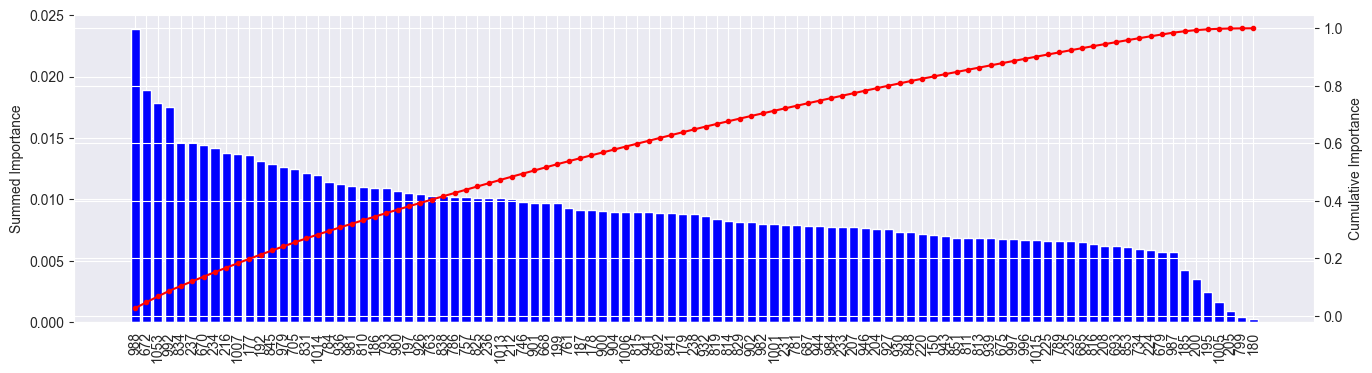

In [25]:
# Calculate feature importances for original columns
importances = pd.DataFrame(
    {
        'Residues': selected_features,
        'Importance': rf.feature_importances_[selected_feature_indices],
        'Columns': df_importance.Residues.apply(lambda x: int(x.split('_')[0]))
    }
)[['Columns', 'Importance']].groupby('Columns').sum()
sorted_importances = importances['Importance'].sort_values(ascending=False)
sorted_features = sorted_importances.index

fig, ax1 = plt.subplots(figsize=(16, 4))

# Bar chart of percentage importance
xvalues = range(len(sorted_features))
ax1.bar(xvalues, sorted_importances, color='b')
ax1.set_ylabel('Summed Importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, np.cumsum(sorted_importances) / np.sum(sorted_importances), color='r', marker='.')
ax2.set_ylabel('Cumulative Importance')
ax2.tick_params(axis='y')

# Rotate x-axis labels
plt.xticks(xvalues, sorted_features)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

plt.show()


In [101]:
# Select only the columns corresponding to the selected features
df_selection = df_unique[importances.index].copy()

df_selection.head()

,150,177,178,179,180,185,186,187,192,195,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,D,V,E,A,N,L,L,I,E,N,...,V,G,A,Q,E,N,L,S,A,G
1,R,T,P,A,N,S,I,V,D,N,...,E,S,V,Q,K,G,L,K,S,R
2,L,T,P,A,N,N,I,V,D,N,...,E,S,V,Q,K,G,L,K,S,R
3,Q,G,Q,Y,N,T,L,A,D,N,...,N,A,A,Q,K,N,L,N,A,G
4,A,T,P,A,N,I,I,V,D,N,...,E,S,V,Q,R,G,L,K,S,R


In [90]:
# Perform MCA
mca = MCA()
mca.fit(df_selection)

# Access the results
coordinates = mca.transform(df_selection)

mca.plot(
    df_selection,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [91]:
# Assuming 'coordinates' is the result of MCA

# Convert the coordinates to a NumPy array
coordinates = np.array(coordinates)

# 1) K-Means
# Define a range of potential number of clusters to evaluate
min_clusters = 2
max_clusters = 10

# Perform clustering for different number of clusters and compute silhouette scores
silhouette_scores = []
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
    kmeans.fit(coordinates)
    labels = kmeans.labels_
    score = silhouette_score(coordinates, labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest silhouette score
kmeans_best_num_clusters = np.argmax(silhouette_scores) + min_clusters

# Perform clustering with the best number of clusters
kmeans = KMeans(n_clusters=kmeans_best_num_clusters, n_init=10)  # Set n_init explicitly
kmeans.fit(coordinates)
kmeans_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# 2) OPTICS
# Define a range of potential number of clusters to evaluate
min_clusters = 3
max_clusters = 10

# Perform clustering for different number of clusters and compute silhouette scores
silhouette_scores = []
for k in range(min_clusters, max_clusters + 1):
    optics_instance = optics(coordinates, eps=1.0, minpts=3, amount_clusters=k)
    optics_instance.process()
    cluster_labels = np.zeros(len(coordinates), dtype=int)
    clusters = optics_instance.get_clusters()
    for cluster_id, cluster in enumerate(clusters):
        cluster_labels[cluster] = cluster_id
    score = silhouette_score(coordinates, cluster_labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest silhouette score
optics_best_num_clusters = np.argmax(silhouette_scores) + min_clusters

# Perform OPTICS clustering with the best number of clusters
optics_instance = optics(coordinates, eps=1.0, minpts=3, amount_clusters=optics_best_num_clusters)
optics_instance.process()
clusters = optics_instance.get_clusters()

# Get cluster labels for each point
optics_cluster_labels = np.zeros(len(coordinates), dtype=int)
for cluster_id, cluster in enumerate(clusters):
    optics_cluster_labels[cluster] = cluster_id


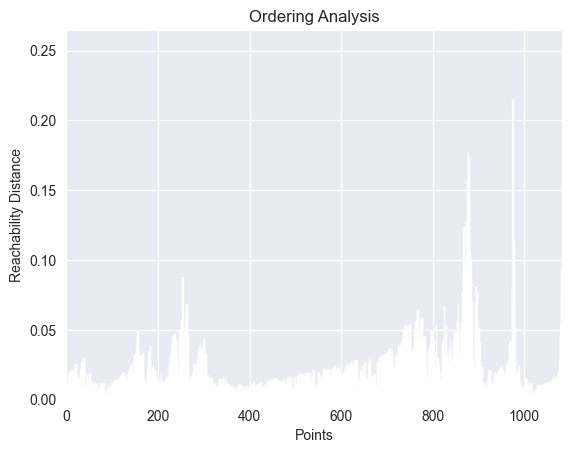

In [92]:
# Plot the ordering analysis
ordering = ordering_analyser(optics_instance.get_ordering())
ordering = ordering.cluster_ordering
plt.figure()
plt.bar(range(0, len(ordering)), ordering[0:len(ordering)], width=1., color='black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.title('Ordering Analysis')
plt.show()

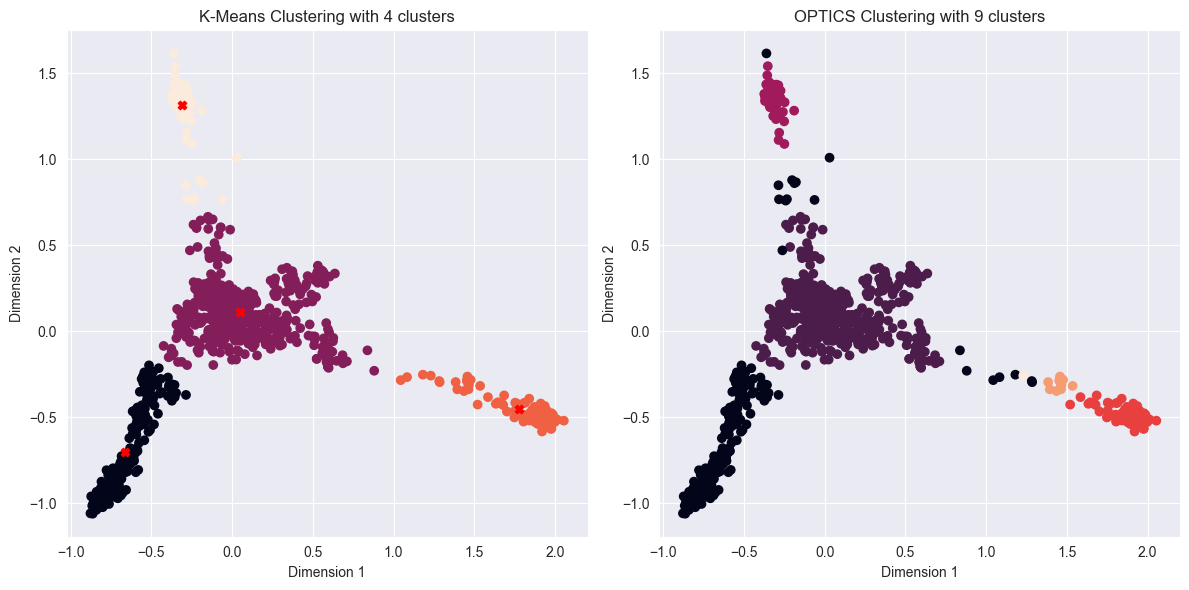

In [93]:
# Create subplots for K-Means and OPTICS scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot K-Means scatter plot
ax1.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans_cluster_labels)
ax1.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_title(f'K-Means Clustering with {kmeans_best_num_clusters} clusters')

# Plot OPTICS scatter plot
ax2.scatter(coordinates[:, 0], coordinates[:, 1], c=optics_cluster_labels)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_title(f'OPTICS Clustering with {optics_best_num_clusters} clusters')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

In [167]:
alphabet = [chr(i).upper() for i in range(ord('a'), ord('z')+1)]
df_cluster = pd.DataFrame()
df_cluster['K-Means'] = pd.Series([alphabet[i] for i in kmeans_cluster_labels])

noise = optics_instance.get_noise()

# Reset the index of the DataFrame
df_cluster = df_cluster.reset_index(drop=True)

# Create a new 'OPTICS' column using np.where()
df_cluster['OPTICS'] = np.where(df_selection.index.isin(noise), '0', '')

for cluster_id, cluster in enumerate(clusters):
    cluster_name = alphabet[cluster_id]
    df_cluster.loc[df_selection.index.isin(cluster), 'OPTICS'] = cluster_name

# Reset the index of the DataFrame
df_cluster = df_cluster.reset_index(drop=True)

In [168]:
df_cluster['K-Means'].value_counts(normalize=True)

K-Means
B    0.568266
A    0.234317
D    0.107934
C    0.089483
Name: proportion, dtype: float64

In [169]:
df_cluster['K-Means'].isna().value_counts(normalize=True)

K-Means
False    1.0
Name: proportion, dtype: float64

In [170]:
df_cluster['OPTICS'].value_counts(normalize=True)

OPTICS
B      0.542435
A      0.210332
C      0.086716
D      0.069188
nan    0.066421
0      0.014760
E      0.009225
F      0.000923
Name: proportion, dtype: float64

In [171]:
df_cluster['OPTICS'].isna().value_counts(normalize=True)

OPTICS
False    1.0
Name: proportion, dtype: float64

In [172]:
def henikoff(data):
    data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    size, length = data_array.shape
    weights = []
    for seq_index in range(size):
        row = data_array[seq_index, :]
        unique_vals, counts = np.unique(row, return_counts=True)
        k = len(unique_vals)
        matrix_row = 1. / (k * counts)
        weights.append(np.sum(matrix_row) / length)
    return pd.Series(weights, index=data.index)

In [173]:
weights = henikoff(df_selection)
print(weights)

0       0.003249
1       0.002728
2       0.002343
3       0.002739
4       0.002860
          ...   
1153    0.002833
1154    0.002729
1155    0.002487
1156    0.002285
1157    0.002827
Length: 1084, dtype: float64


In [174]:
df_res = mca.column_coordinates(df_selection).loc[selected_features]
df_res.head()

,0,1
150_A,-0.172470,-0.094876
150_D,-0.266280,-0.262887
150_E,-0.453494,-0.386761
150_H,0.018019,0.009074
150_I,0.197229,0.836675


In [175]:
# Create an empty graph
G = nx.Graph()
for idx in df_res.index:
    col, aa = idx.split('_')
    col = int(col)
    rows = df_selection.index[df_selection[col] == aa].tolist()
    # Filter and sum values based on valid indices
    p = weights.iloc[[i for i in rows if i < len(weights)]].sum()
    # Add a node with attributes
    # print(f'{seq3(aa)}{col}', idx, aa, col, df_res.loc[idx,0], df_res.loc[idx,1], rows, p)
    G.add_node(
        f'{seq3(aa)}{col}',
        idx=idx,
        aa=aa,
        col=col,
        coord=(
            df_res.loc[idx,0],
            df_res.loc[idx,1]
        ),
        rows=rows,
        p=p
    )
G.nodes

NodeView(('Ala150', 'Asp150', 'Glu150', 'His150', 'Ile150', 'Leu150', 'Pro150', 'Arg150', 'Thr150', 'Val150', 'Cys177', 'Glu177', 'Phe177', 'Gly177', 'Ile177', 'Leu177', 'Thr177', 'Val177', 'Tyr177', 'Ala178', 'Asp178', 'Glu178', 'His178', 'Lys178', 'Asn178', 'Pro178', 'Arg178', 'Ala179', 'Cys179', 'Phe179', 'Gly179', 'Asn179', 'Ser179', 'Thr179', 'Tyr179', 'Asn180', 'Phe185', 'Ile185', 'Leu185', 'Met185', 'Thr185', 'Val185', 'Ala186', 'Phe186', 'Gly186', 'Ile186', 'Leu186', 'Met186', 'Gln186', 'Thr186', 'Val186', 'Tyr186', 'Ala187', 'Cys187', 'His187', 'Ile187', 'Leu187', 'Met187', 'Gln187', 'Thr187', 'Val187', 'Trp187', 'Asp192', 'Glu192', 'Ala195', 'Gly195', 'Asn195', 'Gln195', 'Ala197', 'Phe197', 'Gly197', 'Asn197', 'Ser197', 'Val197', 'Tyr197', 'Ala199', 'Cys199', 'Ile199', 'Lys199', 'Leu199', 'Met199', 'Asn199', 'Gln199', 'Arg199', 'Thr199', 'Val199', 'Asp200', 'Glu200', 'Cys204', 'Gly204', 'Pro204', 'Ser204', 'Thr204', 'Tyr204', 'Leu205', 'Tyr205', 'Ala207', 'Cys207', 'Phe207', 

In [176]:
for u in G.nodes:
    print(u, G.nodes[u])

Ala150 {'idx': '150_A', 'aa': 'A', 'col': 150, 'coord': (-0.1724699199845814, -0.09487576655150212), 'rows': [4, 8, 75, 271, 622, 681, 783, 816, 932, 1006, 1014, 1032, 1053, 1145], 'p': 0.03729166530437384}
Asp150 {'idx': '150_D', 'aa': 'D', 'col': 150, 'coord': (-0.26628035490995594, -0.262887175859003), 'rows': [0, 13, 18, 21, 22, 44, 67, 68, 69, 83, 85, 86, 92, 97, 98, 99, 105, 107, 127, 128, 129, 139, 146, 156, 164, 165, 171, 174, 175, 176, 177, 179, 181, 187, 189, 191, 193, 194, 195, 196, 197, 198, 199, 206, 207, 209, 210, 212, 217, 220, 221, 223, 239, 240, 243, 261, 270, 278, 289, 291, 292, 295, 299, 302, 308, 310, 311, 315, 322, 330, 332, 343, 347, 349, 351, 358, 363, 367, 377, 406, 409, 427, 428, 433, 434, 445, 446, 447, 448, 449, 458, 459, 463, 464, 465, 478, 481, 491, 495, 498, 499, 500, 510, 513, 519, 526, 528, 540, 541, 566, 567, 572, 574, 575, 587, 588, 589, 593, 594, 597, 598, 600, 616, 617, 649, 650, 653, 655, 657, 661, 667, 668, 675, 683, 684, 692, 701, 709, 714, 735, 7